In [2]:
import numpy as np
import os
import pandas as pd
import math

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u

from eventio.simtel.simtelfile import SimTelFile
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
path = ['/mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/pxt_', '/LCT5/nsb_0.1076/Cherenkov/light_emission/output/']

p_xt = [0.08]
PDE = [0.4]

path_main = '/mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/pxt_'
path_nsb = ['/nsb_0.1103/light_emission/output/', '/nsb_0.109/light_emission/output/', '/nsb_0.1076/light_emission/output/', '/nsb_0.0734/light_emission/output/']

files = ['ff-1m_r_1nphot_2000000_dist_500_radius_150_Cherenkov_event.simtel.gz', 'ff-1m_r_2nphot_6000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
         'ff-1m_r_1nphot_10000000_dist_500_radius_150_Cherenkov_event.simtel.gz', 'ff-1m_r_3nphot_14000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
         'ff-1m_r_2nphot_20000000_dist_500_radius_150_Cherenkov_event.simtel.gz', 'ff-1m_r_4nphot_50000000_dist_500_radius_150_Cherenkov_event.simtel.gz', 
         'ff-1m_r_3nphot_100000000_dist_500_radius_150_Cherenkov_event.simtel.gz', 'ff-1m_r_4nphot_200000000_dist_500_radius_150_Cherenkov_event.simtel.gz', 
         'ff-1m_r_5nphot_400000000_dist_500_radius_150_Cherenkov_event.simtel.gz', 'ff-1m_r_5nphot_600000000_dist_500_radius_150_Cherenkov_event.simtel.gz']

n_pe = ['2 p.e.', '5 p.e.', '10 p.e.', '100 p.e.', '200 p.e.', '500 p.e.']

output_dir = '/home/andrii/work/sim_telarray/charge_resolution/'

In [4]:
try:
    os.makedirs(output_dir, exist_ok=True)
    print("Directory ", output_dir, " Created ")
except FileExistsError:
    print("Directory ", output_dir, " already exists")

Directory  /home/andrii/work/sim_telarray/charge_resolution/  Created 


In [5]:
def plot_event(n_events, file):
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    for event in source:
        print(event.index)
        camgeom = source.subarray.tel[1].camera.geometry

        fig, (ax0, ax1) = plt.subplots(1, 2)
        disp0 = CameraDisplay(ax=ax0, geometry=camgeom)
        disp1 = CameraDisplay(ax=ax1, geometry=camgeom)

 
        title = "Sum of samples\n in waveforms : event {} ".format( int(event.index.event_id/100) )
        disp = CameraDisplay(ax=ax0, geometry=camgeom, title=title)
        disp.image = event.r0.tel[1].waveform[0].sum(axis=1)
        
        title = "True Image : event {} ".format( int(event.index.event_id/100 ))
        disp = CameraDisplay(ax=ax1, geometry=camgeom, title=title)
        disp.image = event.simulation.tel[1].true_image

        disp.cmap = plt.cm.viridis
        disp.add_colorbar()
        disp.set_limits_percent(95)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'diplay_r150_pe200_{}.png'.format(event.index.event_id)), dpi=800)



In [6]:
def get_n_pe(n_events, file):

    pe_true_map  = []
    pe_true_map_mean = []

    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    for event in source:
        pe_true_map.append(event.simulation.tel[1].true_image)
      
    pe_true_map_mean = np.mean(pe_true_map, axis = 0)
    return pe_true_map, pe_true_map_mean

In [7]:
def ana_waveforms(n_events, file, left_r, right_r):


    baseline  = []
    amplitude = []
    time = []
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)

    for event in source:
        
        y = event.r0.tel[1].waveform[0]
        y_trans = np.transpose(y)
        
        time_tmp = np.argmax(y_trans[left_r:right_r], axis = 0)
        baseline_tmp = np.mean(y_trans[:left_r], axis = 0)
        
        time.append(time_tmp)
        baseline.append(baseline_tmp)
        
        amplitude.append( np.max(y_trans[left_r:right_r], axis = 0) - baseline_tmp)
        

    baseline = np.transpose(baseline)
    amplitude = np.transpose(amplitude)
        
    return baseline, amplitude

In [8]:
def calc_charge_resolution(n_events, file, pxt, baseline, amplitude):
    
    amplitude_corrected = []
    amplitude_mean = []
    std_list = []
    charge_resolution = []
    charge_resolution_err = []
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    xt = pxt
    xt_mean = xt/(1. - xt)
    
    amplitude_corrected = ( amplitude*(1 - xt_mean) )
    amplitude_mean = np.mean(amplitude_corrected, axis = 1)
    
    amplitude_mean_tmp = [amplitude_mean]*n_events
    amplitude_mean_tmp = np.array(amplitude_mean_tmp).T
    
    ampli_sum = np.sum( (amplitude_corrected - amplitude_mean_tmp)**2, axis=1)
    
    amplitude_std = np.sqrt(ampli_sum/(n_events-1))
    amplitude_mean_err = amplitude_std/(math.sqrt(n_events))
    
    charge_resolution = amplitude_std/amplitude_mean
    
    charge_resolution_err = (amplitude_std*amplitude_mean_err)/(amplitude_mean*amplitude_mean)
    
    return charge_resolution, charge_resolution_err

In [9]:
def save_to_file(file_name, mean_pe, charge_resolution, charge_resolution_err):
    
    file_object  = open(file_name, "w") 
    
    file_object.write("pixel \t mean p.e \t mean_charge_resolution \t mean_charge_resolution_err \n")
    
    for line in range(len(mean_pe)):
        file_object.write("{}\t {:.18f}\t {:.18f}\t {:.18f}\n".format(line, mean_pe[line], charge_resolution[line], charge_resolution_err[line]))
        
        
    file_object.close()

In [9]:
#files = files[6:]
files

['ff-1m_r_1nphot_2000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
 'ff-1m_r_2nphot_6000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
 'ff-1m_r_1nphot_10000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
 'ff-1m_r_3nphot_14000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
 'ff-1m_r_2nphot_20000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
 'ff-1m_r_4nphot_50000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
 'ff-1m_r_3nphot_100000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
 'ff-1m_r_4nphot_200000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
 'ff-1m_r_5nphot_400000000_dist_500_radius_150_Cherenkov_event.simtel.gz',
 'ff-1m_r_5nphot_600000000_dist_500_radius_150_Cherenkov_event.simtel.gz']

In [10]:
file_to_ana = files[-5]
file_to_ana

'ff-1m_r_4nphot_50000000_dist_500_radius_150_Cherenkov_event.simtel.gz'

In [33]:
def ana_waveforms(n_events, pixel, file, left_r, right_r):
###########################################

    baseline  = []
    amplitude = []
    charge = []
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)

    for event in source:
        
        y = event.r0.tel[1].waveform[0][pixel]
        
        baseline_tmp = np.mean(y[:left_r])
        baseline.append(baseline_tmp)
        
        amplitude.append( np.max(y[left_r:right_r]) - baseline_tmp)
        charge.append( np.sum(y[left_r:right_r] - baseline_tmp) )
        
    return baseline, amplitude, charge

In [21]:
def get_waveforms(n_events, pixel, file):
###########################################

    baseline  = []
    amplitude = []
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)

    for event in source:
        
        y = event.r0.tel[1].waveform[0][pixel]
        
    return y

In [34]:
n_events = 100
p_xt = 0.08

file_to_ana = files[-5]

print("start with : ", path[0]+str(p_xt) + path[1] + file_to_ana)


baseline_tmp_5, amplitude_tmp_5, charge_5 = ana_waveforms(n_events, 100, path[0]+str(p_xt) + path[1] + file_to_ana, 24, 30)

start with :  /mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/pxt_0.08/LCT5/nsb_0.1076/Cherenkov/light_emission/output/ff-1m_r_4nphot_50000000_dist_500_radius_150_Cherenkov_event.simtel.gz


In [35]:
file_to_ana = files[-2]
baseline_tmp_2, amplitude_tmp_2, charge_2 = ana_waveforms(n_events, 100, path[0]+str(p_xt) + path[1] + file_to_ana, 24, 30)

In [15]:
len(amplitude_tmp[0])

100

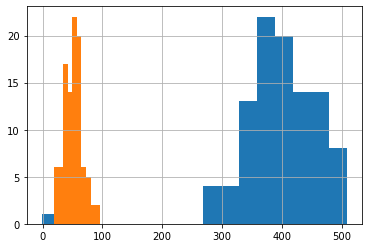

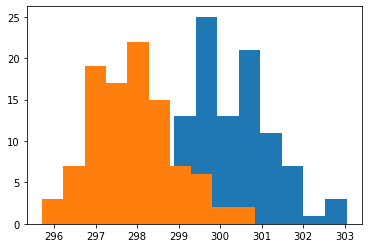

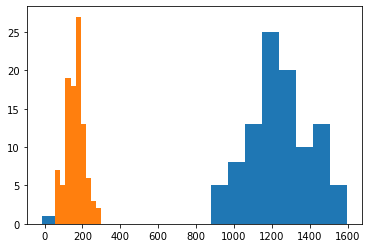

In [36]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp


n_events, bins, patches = plt.hist(amplitude_tmp, bins='auto')
plt.hist(amplitude_tmp_5, bins='auto')
plt.grid(True)

mean = np.mean(amplitude_tmp)
std = np.std(amplitude_tmp)

#popt, pcov = curve_fit(gauss_function, bins[:-1], n_events, p0 = [1, mean, std])
#plt.plot(bins[:-1], gauss_function(bins[:-1], *popt), '-', label='fit')

plt.show()

plt.hist(baseline_tmp, bins='auto')
plt.hist(baseline_tmp_5, bins='auto')

plt.show()

plt.hist(charge_2, bins='auto')
plt.hist(charge_5, bins='auto')

plt.show()

In [23]:
file_to_ana = files[-5]
ampli_5 = get_waveforms(1, 100, path[0]+str(p_xt) + path[1] + file_to_ana)

In [26]:
file_to_ana = files[-2]
ampli_2 = get_waveforms(1, 100, path[0]+str(p_xt) + path[1] + file_to_ana)

In [24]:
time = np.arange(0, len(ampli_5),1)

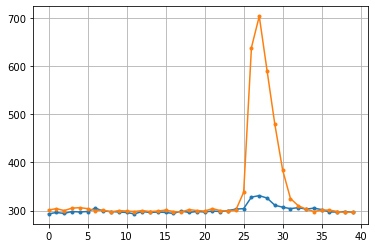

In [29]:
plt.plot(time, ampli_5, '.-')
plt.plot(time, ampli_2, '.-')
plt.grid(True)

In [3]:
def calc_poisson(x, mean, xt):
    x = int(x)
    
    try:
        my_pow = (mean + xt)**(x-1)
    except:
        my_pow = (int(mean + xt))**(x-1)
    #p1 = mean*math.pow(mean + xt*x, x-1)
    p1 = mean*my_pow
    #print(mean, ' ', xt, ' ', x-1)
    p2 = math.exp(-mean - xt*x)
    p3 = math.factorial(x)
    
    return p1*p2/p3

In [354]:
120**200

68588169039290511743443148949538558612744826430307618212802425663277194488051379741338056077927252239527291405784149473939925577529771313777065603197726897018924041971842254904438277686756473109627430567111628003737600000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [7]:
def gaussian(x, mu, sig):
    
    result = (np.exp( -0.5*np.power( ((x - mu)/sig), 2.) ))/(sig*np.power(2.*np.pi, 0.5) )
    
    return result

In [8]:
def spev2(x, mean, gain, amplitude, sigma_e, sigma_g, shift, p_xt):
    #mean = 1
    #gain = 1
    #amplitude = 1
    #n_peaks = 10
    #sigma_e = 0#2.80682e-04/5.88149e-04
    #sigma_g = 0.1790991738488036#1.05337e-04/5.88149e-04
    #shift = .0
    #p_xt = 0.0
    
    #  - Gain               :  5.88149e-04 V
    #  - Sigma electronics  :  2.80682e-04 V
    #  - SiPM gain smearing :  1.05337e-04 V (in Volts)
    #  - SiPM gain smearing :  0.1790991738488036 (in units of p.e.)
    #  - Optical crosstalk  :  0.08 (agreed upon common value)
    
    f_result = 0.0
    p_xt = math.fabs(p_xt)
    
    n_peaks = np.arange(0,90,1)
    
    for i_peak in n_peaks:
            
        sigma = math.sqrt(sigma_e*sigma_e + i_peak*sigma_g*sigma_g)
        f_result = f_result + (amplitude/sigma)*( calc_poisson(i_peak, mean, p_xt) )*(gaussian(x, i_peak*gain+shift, sigma))/3.2
        #else:
        #    f_result = 0.0 
        
    return f_result

In [9]:
x = np.arange(-10, 200, 0.01)

In [10]:
f = spev2(x, 7, 1, 1, 0.19, 0.114, 0.0, 0.08)

<function matplotlib.pyplot.show(close=None, block=None)>

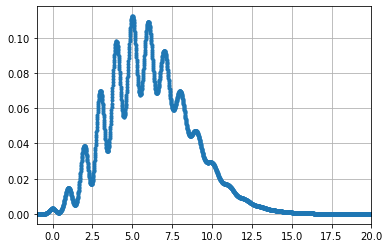

In [11]:
plt.plot(x, f, '.-')
plt.xlim([-1, 20])
plt.grid()
plt.show

#plt.hist(f*x)
#plt.show

In [1]:
np.sum(f)

NameError: name 'np' is not defined

In [12]:
def get_mean(x, y):
    
    x_arr = np.array(x)
    y_arr = np.array(y)
    
    return np.sum(x_arr*y_arr)/np.sum(y_arr)

In [13]:
def get_std(x, y, mean):
    
    x_arr = np.array(x)
    y_arr = np.array(y)
   
    std = np.sum( (x_arr*y_arr - mean)*(x_arr*y_arr - mean) )
    std = math.sqrt(std/np.sum(x_arr*y_arr ))
    
    print(std)
    
    return std

In [14]:
def get_mena_std(x, f):
    data = []

    for point in range(len(f)):
        
        l = [x[point]]*int(100000000*f[point])
        data.append(l)
        
        #for nevents in range(int(100000000*f[point])):
        #    data.append(x[point])
            
    return np.mean(data), np.std(data)

In [433]:
data = []

for point in range(len(f)):
    
    for nevents in range(int(1000*f[point])):
        data.append(x[point])

In [434]:
data

[]

In [ ]:
m, s = get_mena_std(x, f)

In [14]:
print(m, ' ', s, ' ', math.sqrt(m), ' ', math.sqrt(30))

1691006.8120422864   8102609.344540031   1300.3871777444924   5.477225575051661


(array([  36.,   35.,   42.,   70.,  105.,  106.,  150.,  175.,  198.,
         261.,  293.,  332.,  406.,  454.,  504.,  592.,  639.,  705.,
         799.,  849.,  924., 1013., 1060., 1135., 1213., 1250., 1322.,
        1380., 1405., 1455., 1498., 1505., 1531., 1540., 1540., 1540.,
        1520., 1502., 1470., 1485., 1400., 1360., 1312., 1261., 1210.,
        1151., 1096., 1035.,  974.,  917.,  858.,  796.,  742.,  684.,
         630.,  578.,  531.,  480.,  438.,  397.,  357.,  320.,  286.,
         254.,  226.,  202.,  175.,  151.,  140.,  109.,  105.,   81.,
          70.,   70.,   45.,   35.,   35.,   35.,   36.]),
 array([ 8.51      ,  8.86025316,  9.21050633,  9.56075949,  9.91101266,
        10.26126582, 10.61151899, 10.96177215, 11.31202532, 11.66227848,
        12.01253165, 12.36278481, 12.71303797, 13.06329114, 13.4135443 ,
        13.76379747, 14.11405063, 14.4643038 , 14.81455696, 15.16481013,
        15.51506329, 15.86531646, 16.21556962, 16.56582278, 16.91607595,
        

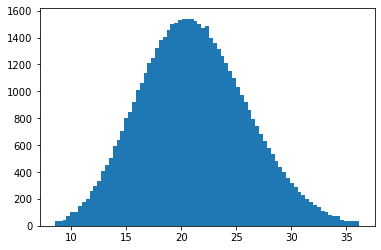

In [264]:
plt.hist(data, bins='auto')

In [265]:
np.mean(data)

21.144685377418277

In [266]:
np.std(data)

4.844928410167638

In [267]:
mean = get_mean(x, f)
mean

21.202682894081065

In [268]:
get_std(x, f, mean)

640.4132174992196


640.4132174992196

(array([1.588e+03, 2.300e+01, 1.200e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([-1.18135942e-06,  3.48121858e-06,  8.14379657e-06, ...,
         6.15914740e-02,  6.15961365e-02,  6.16007991e-02]),
 <BarContainer object of 13212 artists>)

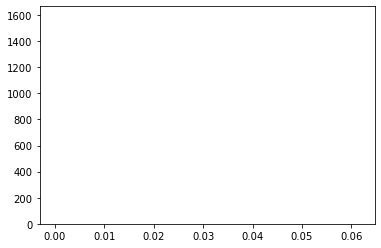

In [161]:
plt.hist(x*f, bins='auto')

In [153]:
len(f)

2200

In [78]:
np.mean(np.sum(f*x))

10.286923713862457

In [308]:
sigma_e = 0.19
sigma_g = 0.114

max_pe = 200

x = np.arange(-10, 500, 0.01)

pde = 1
#pxt = 1. + 0.08/(1.-0.08)
pxt = 0.08
print('pxt : ',pxt)

pe_range = np.arange(1, 200, 10)
pe_det = []

resolution = []
cr_theory = []
cr_poisson = []
mean_det = []
std_det = []

for i_pe in pe_range:
    
    f = spev2(x, i_pe, 1, 1, sigma_e, sigma_g, 0.0, pxt)
    
    mean_tmp, std_tmp = get_mena_std(x, f)
    mean_det.append(mean_tmp)
    std_det.append(std_tmp)
    
    cr_theory.append(std_tmp/mean_tmp)
    
    cr_poisson.append( 1./math.sqrt(i_pe) )
    
    #for pe_test in pe_detected:
        
    #    if(pe_test>0):
    
    #print(pe_detected)
    
    #    pe_det.append(pe_detected)
    
    #    cr_theory.append( (math.sqrt(sigma_e*sigma_e + pe_detected*sigma_g*sigma_g ))/(pe_detected) )
    
    #    
    

pxt :  0.08


In [312]:
print(cr_theory, ' ', pe_range)

[1.139120173943083, 0.3188187681920732, 0.2231588859983661, 0.18001111683206886, 0.15384301619496157, 0.1359885026112327, 0.1227844877930083, 0.1001466771498323, 0.06907791619744554, 0.04195731310754685, 0.012384485822239031, nan, nan, nan, nan, nan, nan, nan, nan, nan]   [  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191]


In [306]:
mean_det

[0.9350895317765531,
 11.419484760925277,
 22.225565072343564,
 33.05888445579225,
 43.90360807888933,
 54.754078880934735,
 65.60646242850407,
 75.1696727272709,
 81.2673968418981,
 84.70530625685858,
 87.40999999999792,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [307]:
std_det

[1.0651793500896631,
 3.6407460648663488,
 4.959832342228385,
 5.9509667121094845,
 6.754263488697816,
 7.445925198875633,
 8.055455885195116,
 7.527992946076553,
 5.613782428629188,
 3.5540070564896626,
 1.082527905721888,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [289]:
i_pe

91

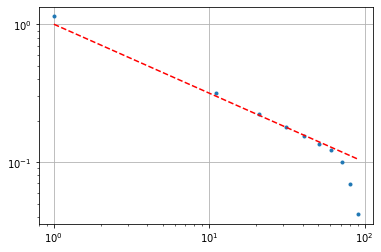

In [296]:
plt.plot(pe_range, cr_theory, '.')
plt.plot(pe_range, cr_poisson, '--r')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

In [19]:
pe_range

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [22]:
cr_theory

[0.01414213562373095,
 0.017320508075688773,
 0.02,
 0.022360679774997897,
 0.024494897427831782,
 0.026457513110645904,
 0.028284271247461905,
 0.030000000000000002,
 0.03162277660168379,
 0.033166247903554,
 0.034641016151377546,
 0.03605551275463989,
 0.03741657386773942,
 0.03872983346207417,
 0.04,
 0.04123105625617661,
 0.042426406871192854,
 0.04358898943540673,
 0.044721359549995794,
 0.0458257569495584,
 0.04690415759823429,
 0.04795831523312719,
 0.04898979485566356,
 0.049999999999999996,
 0.05099019513592785,
 0.05196152422706632,
 0.05291502622129181,
 0.05385164807134504,
 0.054772255750516606,
 0.055677643628300216,
 0.0565685424949238,
 0.05744562646538029,
 0.05830951894845301,
 0.05916079783099616,
 0.060000000000000005,
 0.0608276253029822,
 0.061644140029689765,
 0.06244997998398398,
 0.06324555320336758,
 0.06403124237432849,
 0.06480740698407861,
 0.06557438524302,
 0.066332495807108,
 0.0670820393249937,
 0.06782329983125268,
 0.06855654600401044,
 0.069282032302